In [25]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from rasterio.plot import show
import folium
import plotly.express as px
from branca.colormap import linear
from folium.plugins import TimeSliderChoropleth
import plotly.graph_objs as go
from urllib.request import urlopen
import json
import numpy as np
import branca.colormap as cm
import os

In [26]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')

In [27]:
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]
len(fire_data)

6373

In [28]:
#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [29]:
#Load data in correctly
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month

In [30]:
def fires_year_plot(data, year):
    telangana_shape.plot()
    fires_year = data[data['year'] == year]
    plt.scatter(fires_year.longitude, fires_year.latitude, c='red', edgecolor = 'black')
    plt.title('Fires Telangana Year ' + str(year))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return(plt.show())

In [31]:
def choropleth_fires_year(geo_points, geo_polygon, year):
    fires_per_district = gpd.sjoin(geo_points, geo_polygon, how="inner", op='intersects')
    fires_per_district_count = fires_per_district.groupby(['Dist_Name', 'year', 'Area'])['fireID'].count().reset_index()
    fires_per_district_count['Normalized'] = fires_per_district_count['fireID'] / (fires_per_district_count['Area'])
    fires_per_district_count = fires_per_district_count[fires_per_district_count['year'] == year]
    new_geo = pd.merge(district_boundaries, fires_per_district_count, on = 'Dist_Name')
    new_geo.plot(column = 'Normalized', cmap = 'Blues', edgecolor = 'black', legend = True)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Amount of Fires per District in Year ' + str(year))
    return(plt.show())

In [32]:
#district_boundaries['centroid'] = district_boundaries.geometry.centroid
#district_boundaries['centroid'] = district_boundaries['centroid'].to_crs(epsg=4326)
#fire_map = folium.Map(location = [fire_data_classified['latitude'].iloc[0], fire_data_classified['longitude'].iloc[0]], zoom_start = 7)
#folium.GeoJson(telangana_shape.geometry).add_to(fire_map)
#folium.GeoJson(district_boundaries.geometry).add_to(fire_map)
#folium.map.CustomPane('labels').add_to(fire_map)
#Adding all fires makes it very slow

#for i in range(0, len(district_boundaries)):
#    popup = '<strong>' + district_boundaries['Dist_Name'].iloc[i] +  '</strong>'
#    marker = folium.Marker(location = [district_boundaries['centroid'].iloc[i].y, district_boundaries['centroid'].iloc[i].x], popup = popup)
#    marker.add_to(fire_map)

#display(fire_map)

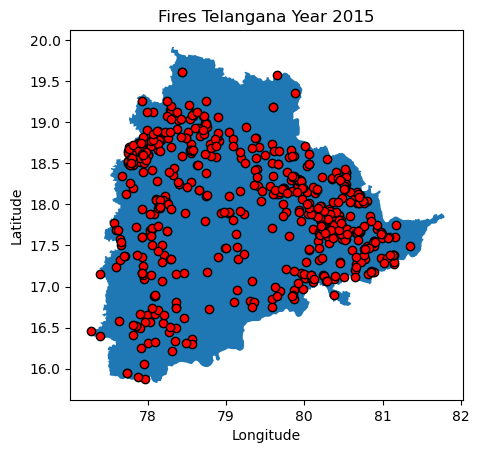

In [33]:
#for i in geo_fire_data['year'].unique():
fires_year_plot(geo_fire_data, 2015)

<ipython-input-31-8e875ea9696d>:2: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326




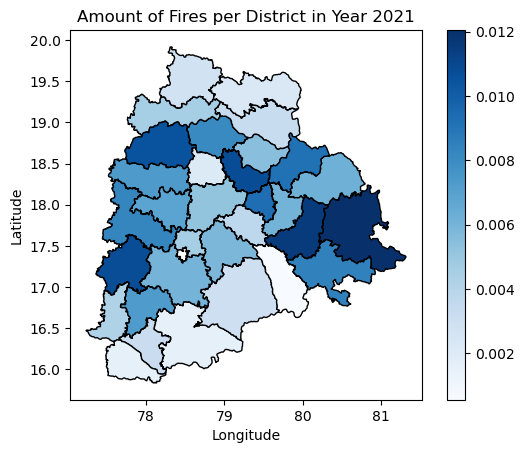

In [34]:
 #for i in geo_fire_data['year'].unique():
choropleth_fires_year(geo_fire_data, district_boundaries, 2021)

In [35]:
fires_per_district = gpd.sjoin(geo_fire_data, district_boundaries, how="inner", op='intersects')
fires_per_district_count = fires_per_district.groupby(['Dist_Name', 'year', 'Area'])['fireID'].count().reset_index()
fires_per_district_count['Normalized'] = fires_per_district_count['fireID'] / (fires_per_district_count['Area'])
new_geo_district = pd.merge(district_boundaries, fires_per_district_count, on = 'Dist_Name')

<ipython-input-35-cc8f4914d226>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326




In [36]:
fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'year', 'Area'])['fireID'].count().reset_index()
fires_per_mandal_count['Normalized'] = fires_per_mandal_count['fireID'] / (fires_per_mandal_count['Area'])
new_geo_mandal = pd.merge(mandal_boundaries, fires_per_mandal_count, on = 'Mandal_Nam')

<ipython-input-36-a831eee5deb5>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326




## Choropleth District Level

In [37]:
len(new_geo_district['Dist_Name'].unique())

32

In [38]:
#Convert the year into a datetime format
new_geo_district['ModifiedDateTime'] = pd.Series(pd.to_numeric(new_geo_district['year'], errors='coerce'), dtype='int64')
new_geo_district['ModifiedDateTime'] = pd.to_datetime(new_geo_district['ModifiedDateTime'].astype('int64').astype('str'), yearfirst=True)

#Convert time to miliseconds (needed for a slider in folium)
datetime_index = pd.DatetimeIndex(new_geo_district['ModifiedDateTime'])
dt_index_ints = datetime_index.astype(int) // 10**9
dt_index = dt_index_ints.astype(str)
new_geo_district['date_sec'] = dt_index

<ipython-input-38-96eb5f9c02c9>:7: FutureWarning:

casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



In [39]:
#Create the colours for each district based on the normalized amount of fires
max_colour = max(new_geo_district['Normalized'])
min_colour = min(new_geo_district['Normalized'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
new_geo_district['colour'] = new_geo_district['Normalized'].map(cmap)

In [40]:
#Create the style dictionary (needed for the slider in folium)
district_list = new_geo_district['Dist_Name'].unique().tolist()
district_idx = range(len(district_list))

style_dict = {}
for i in district_idx:
    district = district_list[i]
    result = new_geo_district[new_geo_district['Dist_Name'] == district]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [41]:
#Rewrite the distribution names into indexes this is important for folium to work
id_dict = {}

for i in district_idx:
    id_dict[str(district_list[i])] = i

new_geo_district['state_id']=new_geo_district['Dist_Name'].map(id_dict)

In [42]:
#Select interesting columns
new_geo_district_choropleth = new_geo_district[['Dist_Name', 'geometry', 'date_sec', 'colour', 'Normalized', 'state_id', 'fireID']]

In [43]:
#Create a choropleth slider per year per district
m = folium.Map([fire_data_classified['latitude'].iloc[0], fire_data_classified['longitude'].iloc[0]], tiles='cartodbpositron', max_bounds=True,  zoom_start=7)

# show the map
#folium.Choropleth(
#    geo_data=new_geo,
#    name="choropleth",
#    data=new_geo,
#    columns=["Dist_Name", "Normalized"],
#    key_on="feature.properties.Dist_Name",
#    fill_color="YlGn",
#    fill_opacity=0.7,
#    line_opacity=.1,
#    legend_name="Normalized Amount of Fires",
#).add_to(m)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

hover = folium.features.GeoJson(new_geo_district_choropleth,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Dist_Name'],
        aliases=['District Name: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(hover)
m.keep_in_front(hover)

slider = TimeSliderChoropleth(
    data=new_geo_district_choropleth.set_index('state_id').to_json(),
    styledict=style_dict).add_to(m)

slider = cmap.add_to(m)
cmap.caption = "Normalized Amount of Fires per year"
folium.LayerControl().add_to(m)

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires')
m.save(outfile='Fires_Per_Year_Per_District.html')


# District Level Visualised Yearly and Monthly

In [44]:
fig = px.line(new_geo_district, x="year", y="Normalized", color='Dist_Name', title='Normalized Amount of Fires per District in Telangana over the Years')
fig.show()

In [45]:
fires_per_district = gpd.sjoin(geo_fire_data, district_boundaries, how="inner", op='intersects')
fires_per_district_count = fires_per_district.groupby(['Dist_Name', 'month', 'Area'])['fireID'].count().reset_index()
fires_per_district_count['Normalized'] = fires_per_district_count['fireID'] / (fires_per_district_count['Area'])
new_geo_district_month = pd.merge(district_boundaries, fires_per_district_count, on = 'Dist_Name')

<ipython-input-45-b9f6c3e0f364>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326




In [46]:
fig = px.line(new_geo_district_month, x="month", y="Normalized", color='Dist_Name', title='Normalized Amount of Fires per District in Telangana Per Month')
fig.show()

## Choropleth Mandal Level Per Year

In [47]:
#Convert the year into a datetime format
new_geo_mandal['ModifiedDateTime'] = pd.Series(pd.to_numeric(new_geo_mandal['year'], errors='coerce'), dtype='int64')
new_geo_mandal['ModifiedDateTime'] = pd.to_datetime(new_geo_mandal['ModifiedDateTime'].astype('int64').astype('str'), yearfirst=True)

#Convert time to miliseconds (needed for a slider in folium)
datetime_index = pd.DatetimeIndex(new_geo_mandal['ModifiedDateTime'])
dt_index_ints = datetime_index.astype(int) // 10**9
dt_index = dt_index_ints.astype(str)
new_geo_mandal['date_sec'] = dt_index
#Create the colours for each district based on the normalized amount of fires
max_colour = max(new_geo_mandal['Normalized'])
min_colour = min(new_geo_mandal['Normalized'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
new_geo_mandal['colour'] = new_geo_mandal['Normalized'].map(cmap)
#Create the style dictionary (needed for the slider in folium)
mandal_list = new_geo_mandal['Mandal_Nam'].unique().tolist()
mandal_idx = range(len(mandal_list))

style_dict = {}
for i in mandal_idx:
    mandal = mandal_list[i]
    result = new_geo_mandal[new_geo_mandal['Mandal_Nam'] == mandal]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict
#Rewrite the distribution names into indexes this is important for folium to work
id_dict = {}

for i in mandal_idx:
    id_dict[str(mandal_list[i])] = i

new_geo_mandal['state_id']=new_geo_mandal['Mandal_Nam'].map(id_dict)

#Select interesting columns
new_geo_mandal_choropleth = new_geo_mandal[['Dist_Name', 'Mandal_Nam', 'geometry', 'date_sec', 'colour', 'Normalized', 'state_id', 'fireID']]
#Create a choropleth slider per year per district
m = folium.Map([fire_data_classified['latitude'].iloc[0], fire_data_classified['longitude'].iloc[0]], tiles='cartodbpositron', max_bounds=True,  zoom_start=7)

# show the map
#folium.Choropleth(
#    geo_data=new_geo,
#    name="choropleth",
#    data=new_geo,
#    columns=["Dist_Name", "Normalized"],
#    key_on="feature.properties.Dist_Name",
#    fill_color="YlGn",
#    fill_opacity=0.7,
#    line_opacity=.1,
#    legend_name="Normalized Amount of Fires",
#).add_to(m)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

hover = folium.features.GeoJson(new_geo_mandal_choropleth,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Mandal_Nam', 'Dist_Name'],
        aliases=['Mandal Name: ', 'District Name: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(hover)
m.keep_in_front(hover)

slider = TimeSliderChoropleth(
    data=new_geo_mandal_choropleth.set_index('state_id').to_json(),
    styledict=style_dict).add_to(m)

slider = cmap.add_to(m)
cmap.caption = "Normalized Amount of Fires per year"
folium.LayerControl().add_to(m)

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires')
m.save(outfile='Fires_Per_Year_Per_Mandal.html')


<ipython-input-47-751c2f2c69c9>:7: FutureWarning:

casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



## Mandal Level Visualised Yearly and Monthly

In [53]:
len(new_geo_mandal['Mandal_Nam'].unique())

501

In [54]:
fig = px.line(new_geo_mandal, x="year", y="Normalized", color='Mandal_Nam', title='Normalized Amount of Fires per Mandal in Telangana over the Years')
fig.show()

In [55]:
fires_per_mandal = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'month', 'Area'])['fireID'].count().reset_index()
fires_per_mandal_count['Normalized'] = fires_per_mandal_count['fireID'] / (fires_per_mandal_count['Area'])
new_geo_mandal_month = pd.merge(mandal_boundaries, fires_per_mandal_count, on = 'Mandal_Nam')

<ipython-input-55-ad2ef7088e15>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326




In [56]:
fig = px.line(new_geo_mandal_month, x="month", y="Normalized", color='Mandal_Nam', title='Normalized Amount of Fires per Mandal in Telangana Per Month')
fig.show()

# Normalized Average Amount of Fires Per Year and Per Month

In [57]:
df = new_geo_district.groupby('year')['Normalized'].mean().reset_index()
fig = px.line(df, x="year", y="Normalized", title='Normalized Average Amount of Fires in Telangana Per Year')
fig.show()

In [58]:
df = new_geo_district_month.groupby('month')['Normalized'].mean().reset_index()
fig = px.line(df, x="month", y="Normalized", title='Normalized Average Amount of Fires in Telangana Per Month')
fig.show()